[Github](https://github.com/leon-pscl/CPE312_Predictive_Analytics_Using_Machine_Learning/tree/621558b0e773c4ceca8564f39841ed8b4177a9d3/Midterm/HOA5.3)

# Activity 5.3: Bagging, Boosting, and Stacking

## Intended Learning Outcomes (ILOs):

* Demonstrate the use of bagging technique for classification and regression tasks
* Demonstrate boosting and stacking models in solving an identified problem.

## Resources:



* Jupyter Notebook<br>
* emails.csv

## Procedure:

For this activity, you need to perform the following tasks:

1. Check the following resources for a review of Bagging and Boosting and Stacking.
   * [Bagging_Exercises.ipynb](https://drive.google.com/file/d/1O-xLD-n1lgqMoXL79FHZcO_ePJd3RgDA/view?usp=sharing)
   * [Boosting_and_Stacking_Exercises_ANSWERS.ipynb](https://drive.google.com/file/d/1jswsZAkeoWJV8TBM3hdB16tbB-KKlh75/view?usp=sharing)

2. Using your own dataset, perform bagging.

### Extract, Transform, Load

In [4]:
#libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
#KNN
from sklearn.neighbors import KNeighborsClassifier
#SVM
from sklearn.svm import SVC
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
#Random Forest and Bagging
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

In [7]:
#import data
email = pd.read_csv('emails.csv')

email.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [10]:
#read dimensions and dtypes
print("Number of datapoints (rows):", email.shape[0])
print("Number of columns:", email.shape[1])
print("\nData types:\n", email.dtypes)

Number of datapoints (rows): 5172
Number of columns: 3002

Data types:
 Email No.     object
the            int64
to             int64
ect            int64
and            int64
               ...  
military       int64
allowing       int64
ff             int64
dry            int64
Prediction     int64
Length: 3002, dtype: object


In [11]:
#Data cleaning
#we don't need the email identifier, so remove it
no_label_email = email.drop(['Email No.'], axis=1)
no_label_email.head()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0


In [12]:
#check for missing values
print("\nMissing values per column:\n", no_label_email.isnull().sum())


Missing values per column:
 the           0
to            0
ect           0
and           0
for           0
             ..
military      0
allowing      0
ff            0
dry           0
Prediction    0
Length: 3001, dtype: int64


### Prep for modelling

In [13]:
#Implement point-biserial correlation to see which columns may have the highest correlation to the prediction
from scipy.stats import pointbiserialr
import pandas as pd

target = 'Prediction'
results = []

#Loop through predictor columns
for col in no_label_email.drop(columns=[target]).select_dtypes(include=np.number).columns:
    corr, p_val = pointbiserialr(no_label_email[target], no_label_email[col])
    results.append({"Feature": col, "Correlation": corr, "AbsCorrelation": abs(corr), "p-value": p_val})

#Put into DataFrame and sort
results_df = pd.DataFrame(results)
top_20 = results_df.sort_values(by="AbsCorrelation", ascending=False).head(20)

print(top_20[['Feature', 'Correlation', 'p-value']])

        Feature  Correlation       p-value
160      thanks    -0.271433  4.926148e-88
37          hpl    -0.266518  7.952302e-85
418       hanks    -0.266070  1.547126e-84
785       thank    -0.262384  3.521933e-82
99         more     0.258152  1.607936e-79
81     attached    -0.236558  1.048551e-66
68        daren    -0.236180  1.711801e-66
52    forwarded    -0.230765  1.761133e-63
42          our     0.228187  4.495713e-62
317     subject    -0.227754  7.714997e-62
2311         hp    -0.225846  8.229589e-61
363        able     0.222219  6.968407e-59
290        best     0.221703  1.301847e-58
2833         ur     0.220253  7.483086e-58
1092        sex     0.220092  9.079039e-58
1361        sec     0.217402  2.241652e-56
242       money     0.217215  2.799293e-56
647        soft     0.213382  2.498362e-54
1615         dr     0.212413  7.671000e-54
2041         mo     0.210056  1.146765e-52


In [16]:
#prep for modelling
X = no_label_email.drop('Prediction', axis=1)
y = no_label_email['Prediction']

#split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

### Bagging

In [14]:
#base learners
knn_model = KNeighborsClassifier(n_neighbors=11)

logreg_model = LogisticRegression(max_iter=1000, random_state=42, verbose=1)

#### Bagging with KNN

In [22]:
#base performance - KNN
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_proba = knn_model.predict_proba(X_test)[:, 1]
print("Base KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("Base KNN ROC-AUC:", roc_auc_score(y_test, knn_proba))

Base KNN Accuracy: 0.8698453608247423
Base KNN ROC-AUC: 0.9333887625592274


In [24]:
#Bagging with KNN as base
bagging_knn = BaggingClassifier(
    estimator=knn_model,
    n_estimators=20,
    max_samples=0.7,
    bootstrap=True,
    random_state=42,
    verbose=1#show progress of each base estimator
)

#Fit the model
bagging_knn.fit(X_train, y_train)

#Make predictions
bag_knn_pred = bagging_knn.predict(X_test)
bag_knn_proba = bagging_knn.predict_proba(X_test)[:, 1]

#Evaluate
print("Bagging + KNN Accuracy:", accuracy_score(y_test, bag_knn_pred))
print("Bagging + KNN ROC-AUC:", roc_auc_score(y_test, bag_knn_proba))


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s finished


Bagging + KNN Accuracy: 0.8640463917525774
Bagging + KNN ROC-AUC: 0.9345788213609546


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s finished


#### Bagging with Logistic Regression

In [25]:
#base performance - Logistic Regression
logreg_model.fit(X_train, y_train)
logreg_pred = logreg_model.predict(X_test)
logreg_proba = logreg_model.predict_proba(X_test)[:, 1]
print("Base Logistic Regression Accuracy:", accuracy_score(y_test, logreg_pred))
print("Base Logistic Regression ROC-AUC:", roc_auc_score(y_test, logreg_proba))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s finished


Base Logistic Regression Accuracy: 0.9710051546391752
Base Logistic Regression ROC-AUC: 0.9910986005790017


In [28]:
#Bagging with Logistic Regression as base
bagging_logreg = BaggingClassifier(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_estimators=20,
    max_samples=0.7,
    bootstrap=True,
    random_state=42,
)

#Fit the model
bagging_logreg.fit(X_train, y_train)

#Make predictions
bag_logreg_pred = bagging_logreg.predict(X_test)
bag_logreg_proba = bagging_logreg.predict_proba(X_test)[:, 1]

#Evaluate
print("Bagging + Logistic Regression Accuracy:", accuracy_score(y_test, bag_logreg_pred))
print("Bagging + Logistic Regression ROC-AUC:", roc_auc_score(y_test, bag_logreg_proba))

Bagging + Logistic Regression Accuracy: 0.9677835051546392
Bagging + Logistic Regression ROC-AUC: 0.9926693179200017


#### **Analysis**

*As seen from the accuracy scores above, bagging yields slightly worse results when using KNN and Logistic Regression as base models. This may be because bagging just reduces variance to improve stability and consequently, improve the results. That's helpful for models that are unstable, such as decision trees, but is actually not helpful for those that are already stable and have low variance, such as KNN and Logistic Regression. As a result, bagging multiple models of these on bootstrapped samples doesn't add much, and may even hurt performance slightly. Bagging also doesn't reduce bias, only variance, so it's not helpful in Logister Regression either.*

*Furthermore, bootstrap sampling reduces the effective traning size. KNN and Logistic Regression benefit more from utilizing the full dataset, so that hurts their performance too.*

#### Bagging with Decision Tree Classifier

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (Base Decision Tree): {'min_samples_split': 3, 'min_samples_leaf': 8, 'max_depth': 10}
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1097
           1       0.81      0.85      0.83       455

    accuracy                           0.90      1552
   macro avg       0.87      0.88      0.88      1552
weighted avg       0.90      0.90      0.90      1552

Confusion Matrix:
 [[1007   90]
 [  69  386]]
Base Decision Tree Accuracy: 0.8975515463917526
Base Decision Tree ROC-AUC: 0.9471555791519329


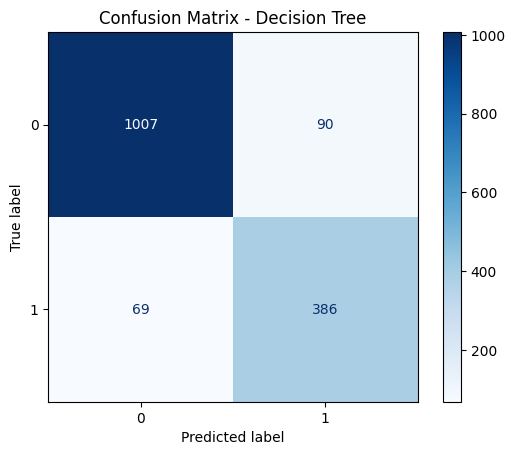

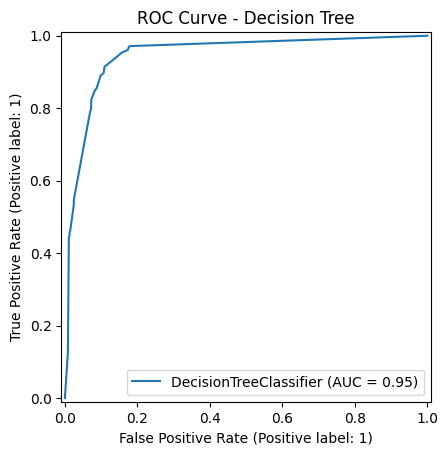

In [33]:
#DecisionTreeClassifier (Base)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import numpy as np

#Parameters for RandomSearch
dt_param_dist = {
    "max_depth": [5, 10, 30, 50],
    "min_samples_split": np.arange(2, 21),
    "min_samples_leaf": np.arange(1, 11)
}

# RandomizedSearch
dt_random = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_param_dist,
    n_iter=20,   # number of random combinations to try
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

#Fit the model
dt_random.fit(X_train, y_train)

#Best model
best_dt = dt_random.best_estimator_
dt_pred = best_dt.predict(X_test)
dt_proba = best_dt.predict_proba(X_test)[:, 1]

#Evaluation metrics
print("Best Params (Base Decision Tree):", dt_random.best_params_)
print("Classification Report:\n", classification_report(y_test, dt_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("Base Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Base Decision Tree ROC-AUC:", roc_auc_score(y_test, dt_proba))

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_dt, X_test, y_test)
plt.title("ROC Curve - Decision Tree")
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (Bagging + Decision Tree): {'n_estimators': 600, 'max_samples': 0.7, 'estimator__min_samples_split': 3, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 20}
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1097
           1       0.92      0.92      0.92       455

    accuracy                           0.95      1552
   macro avg       0.94      0.94      0.94      1552
weighted avg       0.95      0.95      0.95      1552

Confusion Matrix:
 [[1060   37]
 [  35  420]]
Bagging + Decision Tree Accuracy: 0.9536082474226805
Bagging + Decision Tree ROC-AUC: 0.99124084666473


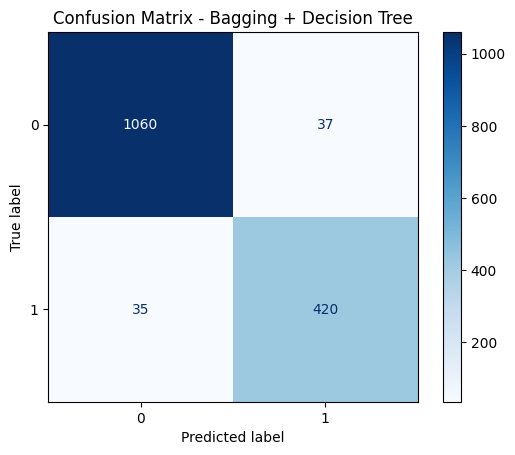

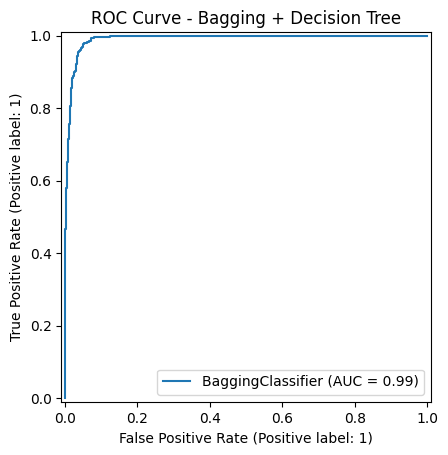

In [35]:
#Bagging With DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import numpy as np

#Parameter distributions
bagging_param_dist = {
    "n_estimators": [100, 300, 600, 1000],#number of trees
    "max_samples": [0.5, 0.7, 1],#fraction of training data
    "estimator__max_depth": [None, 5, 10, 20, 30],
    "estimator__min_samples_split": np.arange(2, 11),
    "estimator__min_samples_leaf": np.arange(1, 6)
}

#Bagging Classifier
bagging_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    bootstrap=True,
    random_state=42
)

#RandomizedSearchCV
bagging_random = RandomizedSearchCV(
    estimator=bagging_dt,
    param_distributions=bagging_param_dist,
    n_iter=20,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

#Fit the model
bagging_random.fit(X_train, y_train)

#Best model evaluation
best_bagging_dt = bagging_random.best_estimator_
bag_dt_pred = best_bagging_dt.predict(X_test)
bag_dt_proba = best_bagging_dt.predict_proba(X_test)[:, 1]

#Eval metrics
print("Best Params (Bagging + Decision Tree):", bagging_random.best_params_)
print("Classification Report:\n", classification_report(y_test, bag_dt_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, bag_dt_pred))
print("Bagging + Decision Tree Accuracy:", accuracy_score(y_test, bag_dt_pred))
print("Bagging + Decision Tree ROC-AUC:", roc_auc_score(y_test, bag_dt_proba))

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_bagging_dt, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Bagging + Decision Tree")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(best_bagging_dt, X_test, y_test)
plt.title("ROC Curve - Bagging + Decision Tree")
plt.show()


#### Random Forest

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1097
           1       0.96      0.97      0.97       455

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552

Confusion Matrix:
 [[1078   19]
 [  12  443]]
Random Forest Accuracy: 0.9800257731958762
Random Forest ROC-AUC: 0.9964458513227883


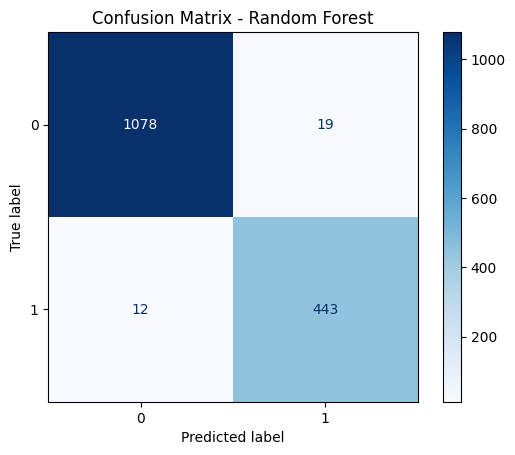

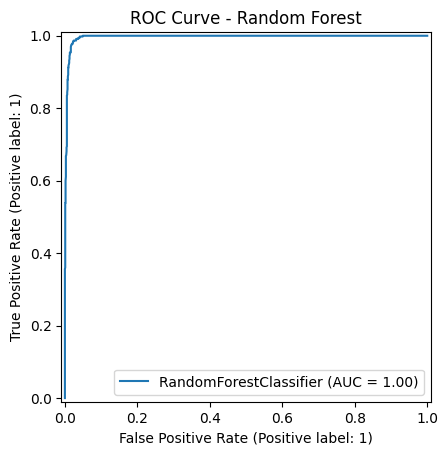

In [40]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt

#Train
rf = RandomForestClassifier(n_estimators=600, random_state=42)
rf.fit(X_train, y_train)

#Predictions
predictions = rf.predict(X_test)
probs = rf.predict_proba(X_test)[:, 1]

#eval metrics
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, predictions))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, probs))

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()


#### **Analysis**

*As seen from the results of using bagging on decision tree classifiers, it greatly improves performance in terms of accuracy and ROC-AUC, meaning that it can differentiate and classify properly at an accurate level. Bagging with decision trees is quite different than random forest too, as Random Forest adds random feature selection, so the trees are less correlated, which can lead to a stronger generalization.*

3. Using your own dataset, perform boosting (AdaBoost, XGBoost, and etc) and stacking.

### Boosting

#### Base (DecisionTreeClassifier)

In [15]:
#DecisionTreeClassifier (Base)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import numpy as np

#Parameters for RandomSearch
dt_param_dist = {
    "max_depth": [5, 10, 30, 50],
    "min_samples_split": np.arange(2, 21),
    "min_samples_leaf": np.arange(1, 11)
}

#RandomizedSearch
dt_random = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_param_dist,
    n_iter=20,#number of random combinations to try
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

#Fit the model
dt_random.fit(X_train, y_train)

#Best model
best_dt = dt_random.best_estimator_
dt_pred = best_dt.predict(X_test)
dt_proba = best_dt.predict_proba(X_test)[:, 1]

#Evaluation metrics
print("Best Params (Base Decision Tree):", dt_random.best_params_)
print("Classification Report:\n", classification_report(y_test, dt_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("Base Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
print("Base Decision Tree ROC-AUC:", roc_auc_score(y_test, dt_proba))

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_dt, X_test, y_test)
plt.title("ROC Curve - Decision Tree")
plt.show()

NameError: name 'X_train' is not defined

#### AdaBoost

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (AdaBoost): {'n_estimators': 300, 'learning_rate': 0.34, 'estimator__max_depth': 3}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1097
           1       0.94      0.98      0.96       455

    accuracy                           0.97      1552
   macro avg       0.96      0.98      0.97      1552
weighted avg       0.98      0.97      0.98      1552

Confusion Matrix:
 [[1068   29]
 [  10  445]]
AdaBoost Accuracy: 0.9748711340206185
AdaBoost ROC-AUC: 0.9954901980426136


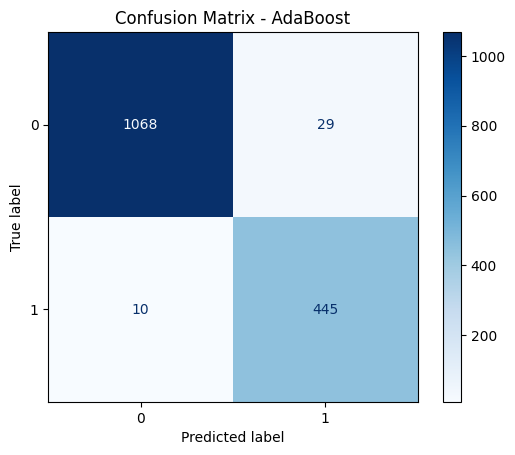

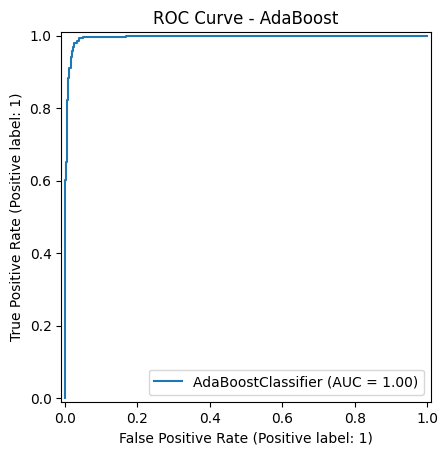

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import numpy as np

#Parameter distributions for RandomizedSearch
ada_param_dist = {
    "n_estimators": [50, 100, 200, 300, 500],
    "learning_rate": np.linspace(0.01, 1.0, 10),#random samples in range
    "estimator__max_depth": [1, 2, 3]#tree depth
}

#Base AdaBoost model
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    random_state=42
)

#RandomSearch
random_search_ada = RandomizedSearchCV(
    estimator=adaboost,
    param_distributions=ada_param_dist,
    n_iter=20,                # number of random combos to try
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_ada.fit(X_train, y_train)

#Best model
best_adaboost = random_search_ada.best_estimator_
ada_pred = best_adaboost.predict(X_test)
ada_proba = best_adaboost.predict_proba(X_test)[:, 1]

#eval metrics
print("Best Params (AdaBoost):", random_search_ada.best_params_)
print("Classification Report:\n", classification_report(y_test, ada_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, ada_pred))
print("AdaBoost Accuracy:", accuracy_score(y_test, ada_pred))
print("AdaBoost ROC-AUC:", roc_auc_score(y_test, ada_proba))

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_adaboost, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - AdaBoost")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(best_adaboost, X_test, y_test)
plt.title("ROC Curve - AdaBoost")
plt.show()

#### XGBoost

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (XGBoost): {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.23555555555555557, 'colsample_bytree': 0.7}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1097
           1       0.95      0.98      0.96       455

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.97      1552
weighted avg       0.98      0.98      0.98      1552

Confusion Matrix:
 [[1072   25]
 [  10  445]]
XGBoost Accuracy: 0.9774484536082474
XGBoost ROC-AUC: 0.9960191130656034


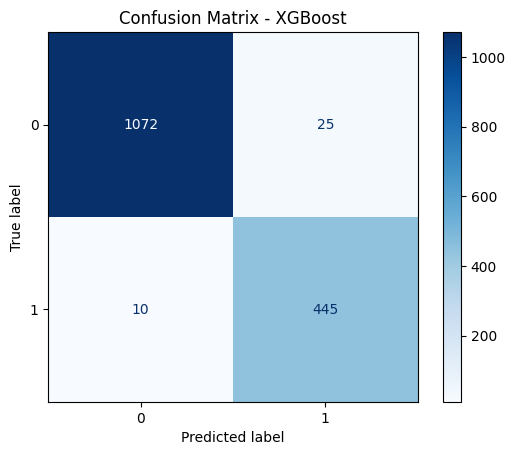

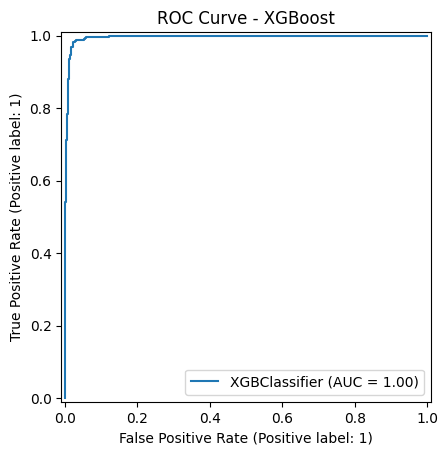

In [54]:
import xgboost as xgb
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import numpy as np

#Parameter distributions for RandomizedSearch
xgb_param_dist = {
    "n_estimators": [100, 300, 500, 800],
    "learning_rate": np.linspace(0.01, 0.3, 10),#different learning rates
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0]
}

#Base XGBoost model
xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
)

#RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,#number of random parameter sets to try
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_xgb.fit(X_train, y_train)

#Best model
best_xgb = random_search_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]

#Evaluation Metrics
print("Best Params (XGBoost):", random_search_xgb.best_params_)
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_proba))

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("ROC Curve - XGBoost")
plt.show()

#### CatBoost

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params (CatBoost): {'learning_rate': 0.20333333333333334, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 8}
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1097
           1       0.95      0.99      0.97       455

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552

Confusion Matrix:
 [[1074   23]
 [   6  449]]
CatBoost Accuracy: 0.9813144329896907
CatBoost ROC-AUC: 0.9969086519679045


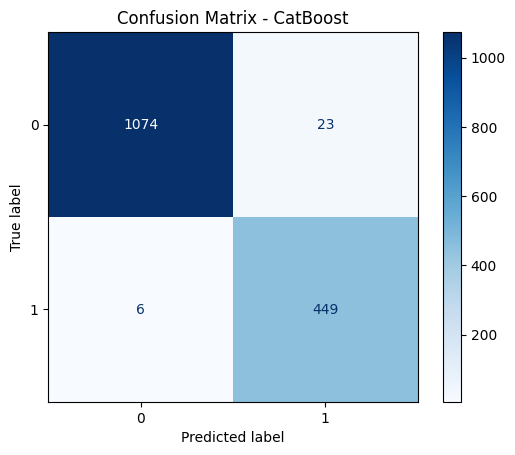

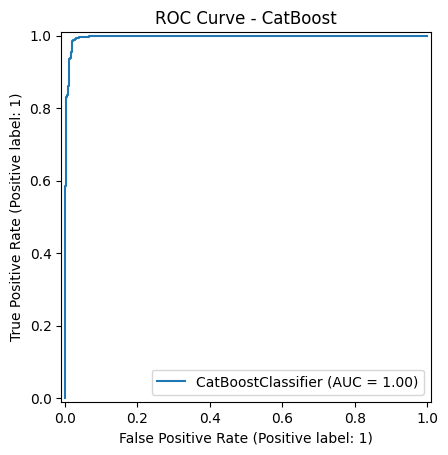

In [58]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

#Parameter distributions for RandomizedSearch
cat_param_dist = {
    "iterations": [200, 300, 500, 800],
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "depth": [4, 6, 8, 10],
    "l2_leaf_reg": [1, 3, 5, 7, 10]
}

#Base CatBoost model
catboost = CatBoostClassifier(
    verbose=0,
    random_state=42
)

#randomsearch
random_search_cat = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=cat_param_dist,
    n_iter=20,#number of random parameter sets to try
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search_cat.fit(X_train, y_train)

#Best model
best_cat = random_search_cat.best_estimator_
cat_pred = best_cat.predict(X_test)
cat_proba = best_cat.predict_proba(X_test)[:, 1]

#eval metrics
print("Best Params (CatBoost):", random_search_cat.best_params_)
print("Classification Report:\n", classification_report(y_test, cat_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, cat_pred))
print("CatBoost Accuracy:", accuracy_score(y_test, cat_pred))
print("CatBoost ROC-AUC:", roc_auc_score(y_test, cat_proba))

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_cat, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(best_cat, X_test, y_test)
plt.title("ROC Curve - CatBoost")
plt.show()

#### Analysis

*Running three boosting models was quite tedious work, but based on the results, CatBoost yielded the highest accuracy amongst the three models, though it also took the longest runtime. XGBoost was close in terms of accuracy and ROC-AUC score, meaning that it can do classification accurately, and it also took the shortest runtime. All three boosting models were big improvements when compared to the DecisionTreeClassifier model, which yielded a less than 90% accurac and less than 95% ROC-AUC score.*

*It should be noted that Randomized Search was used instead of GridSearch for faster processing of the models, and for a fair comparison, each model ran through 5-fold cross-validations across 20 candidates for 100 fits.*

### Stacking

*I used RandomForest and SVM Classifier as base learners, then used LogisticRegression as the final estimator for the StackingClassifier model. Then, I ran GridSearch on the final estimator to search for the best possible parameters. Due to hardware constraints, I was only able to run 30 fits (5 folds for each of 6 candidates).*

*This combination of models was chosen to increase diversity amongst the base models, wherein only one of them produces correlated predictions, and a simple meta-learner/final estimator.*

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params for Meta-Learner (RF): {'final_estimator__C': 1, 'final_estimator__solver': 'lbfgs'}
Best ROC-AUC Score (CV): 0.9960291726668835
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1097
           1       0.96      0.97      0.96       455

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.97      1552
weighted avg       0.98      0.98      0.98      1552

Confusion Matrix:
 [[1077   20]
 [  14  441]]
Stacking Test Accuracy: 0.9780927835051546
Stacking Test ROC-AUC: 0.9971590852174261


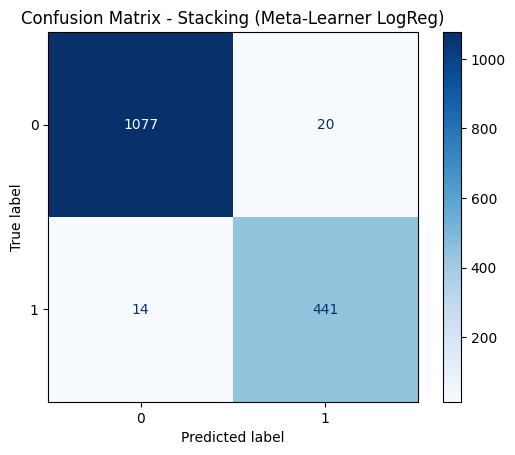

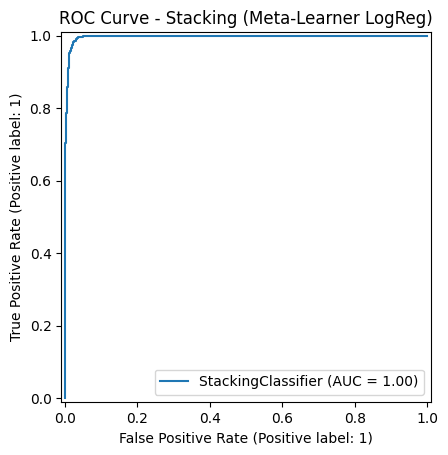

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

#Base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=600,random_state=42)),
    ('svc', SVC(probability=True, kernel="linear", random_state=42))
]

#Stacking model
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

#Parameter distributions for GridSearch
param_dist = {
    "final_estimator__C": [0.01, 0.1, 1],
    "final_estimator__solver": ["lbfgs", "liblinear"]
}


#GridSearch for final_estimator
grid_search = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_dist,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=10
)

grid_search.fit(X_train, y_train)

#Best model
best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test)
test_proba = best_model.predict_proba(X_test)[:, 1]

#eval metrics
print("Best Params for Meta-Learner (RF):", grid_search.best_params_)
print("Best ROC-AUC Score (CV):", grid_search.best_score_)
print("Classification Report:\n", classification_report(y_test, test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("Stacking Test Accuracy:", accuracy_score(y_test, test_pred))
print("Stacking Test ROC-AUC:", roc_auc_score(y_test, test_proba))

#Store results of eval
stacking_results = {
    "Best_Params": grid_search.best_params_,
    "CV_ROC_AUC": grid_search.best_score_,
    "Test_Accuracy": accuracy_score(y_test, test_pred),
    "Test_ROC_AUC": roc_auc_score(y_test, test_proba),
    "Classification_Report": classification_report(y_test, test_pred, output_dict=True),
    "Confusion_Matrix": confusion_matrix(y_test, test_pred)
}

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Stacking (Meta-Learner LogReg)")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Stacking (Meta-Learner LogReg)")
plt.show()

4. For stacking, identify the different models you used and their performances vs their performance when stacked.

#### RandomForest Only vs when stacked

Random Forest
Accuracy: 0.9800257731958762
ROC-AUC: 0.9964458513227883
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1097
           1       0.96      0.97      0.97       455

    accuracy                           0.98      1552
   macro avg       0.97      0.98      0.98      1552
weighted avg       0.98      0.98      0.98      1552

Confusion Matrix:
 [[1078   19]
 [  12  443]]
Comparison
Stacking Accuracy: 0.9780927835051546
RandomForest Accuracy  : 0.9800257731958762
Stacking ROC-AUC : 0.9971590852174261
RandomForest ROC-AUC   : 0.9964458513227883


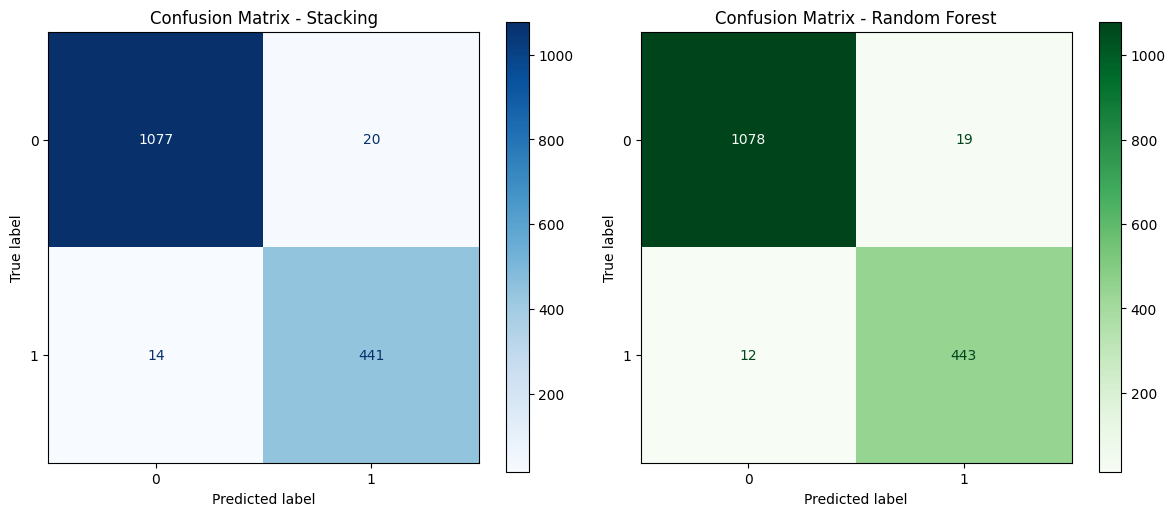

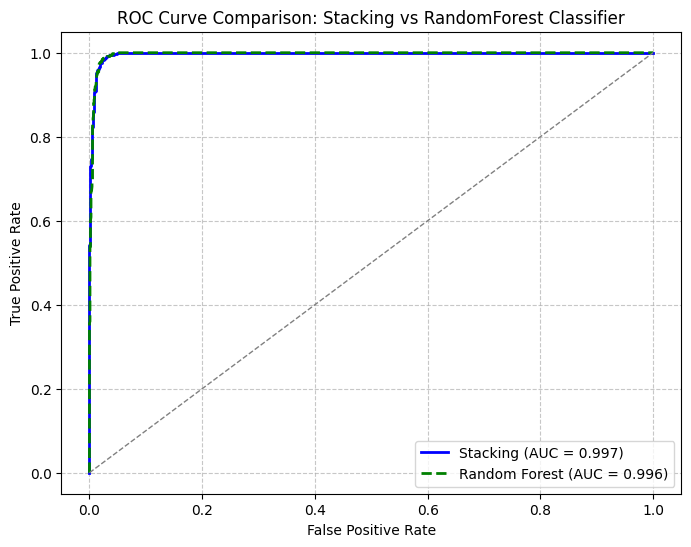

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

rf = RandomForestClassifier(n_estimators=600, random_state=42)

rf.fit(X_train, y_train)


#Predictions
rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

#Eval metrics
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

#Store results
rf_results = {
    "Accuracy": accuracy_score(y_test, rf_predictions),
    "ROC_AUC": roc_auc_score(y_test, rf_probs),
    "Classification_Report": classification_report(y_test, rf_predictions, output_dict=True),
    "Confusion_Matrix": confusion_matrix(y_test, rf_predictions)
}

#Compare with stacking
print("Comparison")
print("Stacking Accuracy:", stacking_results["Test_Accuracy"])
print("RandomForest Accuracy  :", rf_results["Accuracy"])
print("Stacking ROC-AUC :", stacking_results["Test_ROC_AUC"])
print("RandomForest ROC-AUC   :", rf_results["ROC_AUC"])



#ROC Curve - Stacking vs RandomForest
fpr_stack, tpr_stack, _ = roc_curve(y_test, test_proba)
roc_auc_stack = auc(fpr_stack, tpr_stack)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

#Plot confusion matrices for Stacking and Random Forest side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Stacking Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Stacking")
#Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    rf, X_test, y_test, cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix - Random Forest")

plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(fpr_stack, tpr_stack, color="blue", lw=2,
         label=f"Stacking (AUC = {roc_auc_stack:.3f})")
plt.plot(fpr_rf, tpr_rf, color="green", lw=2, linestyle="--",
         label=f"Random Forest (AUC = {roc_auc_rf:.3f})")

#Diagonal line(random classifier)
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")

plt.title("ROC Curve Comparison: Stacking vs RandomForest Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

#### SVC Only vs when stacked

Support Vector Classifier
Accuracy: 0.9568298969072165
ROC-AUC: 0.9814699430013923
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1097
           1       0.92      0.93      0.93       455

    accuracy                           0.96      1552
   macro avg       0.95      0.95      0.95      1552
weighted avg       0.96      0.96      0.96      1552

Confusion Matrix:
 [[1062   35]
 [  32  423]]
Comparison
Stacking Accuracy: 0.9780927835051546
SVC Accuracy     : 0.9568298969072165
Stacking ROC-AUC : 0.9971590852174261
SVC ROC-AUC      : 0.9814699430013923


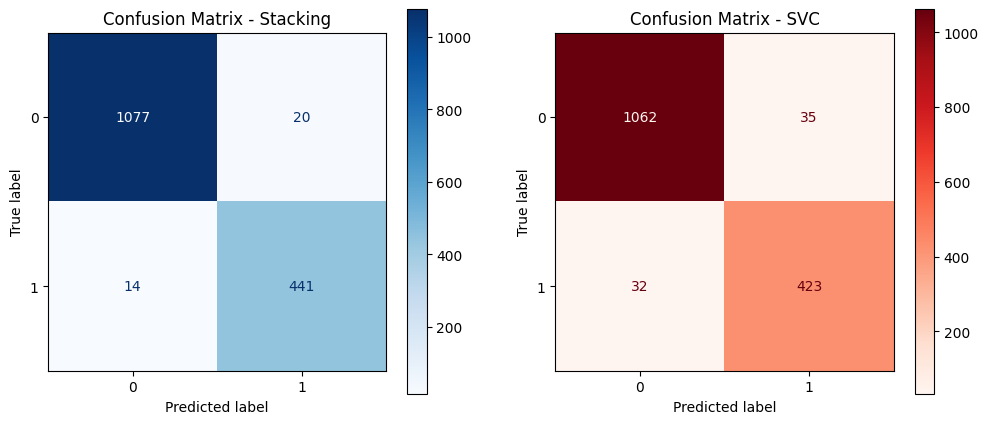

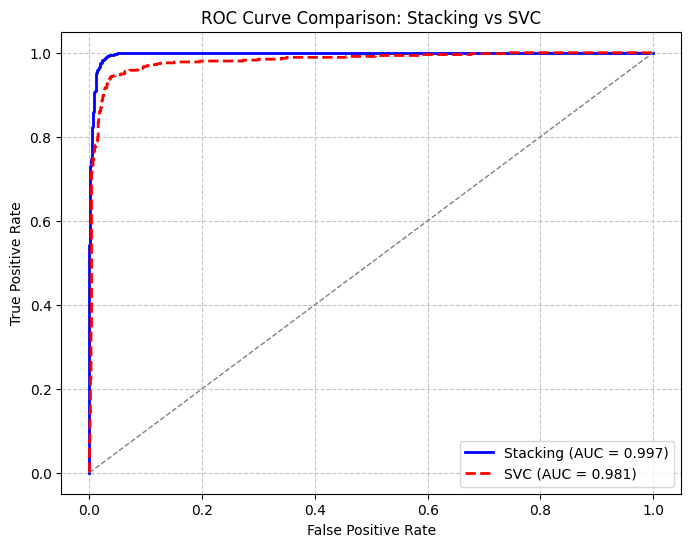

In [62]:
from sklearn.svm import SVC
svc_model = SVC(probability=True, kernel="linear", random_state=42)
svc_model.fit(X_train, y_train)
#Predictions
svc_pred = svc_model.predict(X_test)
svc_proba = svc_model.predict_proba(X_test)[:, 1]

#eval metrics
print("Support Vector Classifier")
print("Accuracy:", accuracy_score(y_test, svc_pred))
print("ROC-AUC:", roc_auc_score(y_test, svc_proba))
print("Classification Report:\n", classification_report(y_test, svc_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, svc_pred))

#Store results
svc_results = {
    "Accuracy": accuracy_score(y_test, svc_pred),
    "ROC_AUC": roc_auc_score(y_test, svc_proba),
    "Classification_Report": classification_report(y_test, svc_pred, output_dict=True),
    "Confusion_Matrix": confusion_matrix(y_test, svc_pred)
}

#Compare with stacking
print("Comparison")
print("Stacking Accuracy:", stacking_results["Test_Accuracy"])
print("SVC Accuracy     :", svc_results["Accuracy"])
print("Stacking ROC-AUC :", stacking_results["Test_ROC_AUC"])
print("SVC ROC-AUC      :", svc_results["ROC_AUC"])

#Plot confusion matrices for Stacking and Random Forest side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#Stacking Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Stacking")
#Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    svc_model, X_test, y_test, cmap="Reds", ax=axes[1])
axes[1].set_title("Confusion Matrix - SVC")

#ROC Curve - Stacking vs SVC
fpr_stack, tpr_stack, _ = roc_curve(y_test, test_proba)
roc_auc_stack = auc(fpr_stack, tpr_stack)

fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_proba)
roc_auc_svc = auc(fpr_svc, tpr_svc)

plt.figure(figsize=(8, 6))
plt.plot(fpr_stack, tpr_stack, color="blue", lw=2,
         label=f"Stacking (AUC = {roc_auc_stack:.3f})")
plt.plot(fpr_svc, tpr_svc, color="red", lw=2, linestyle="--",
         label=f"SVC (AUC = {roc_auc_svc:.3f})")

#Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")

plt.title("ROC Curve Comparison: Stacking vs SVC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


#### Logistic Regression Only vs when stacked

Logistic Regression
Accuracy: 0.9710051546391752
ROC-AUC: 0.9910986005790017
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1097
           1       0.94      0.96      0.95       455

    accuracy                           0.97      1552
   macro avg       0.96      0.97      0.97      1552
weighted avg       0.97      0.97      0.97      1552

Confusion Matrix:
 [[1071   26]
 [  19  436]]
Comparison
Stacking Accuracy: 0.9780927835051546
LogReg Accuracy  : 0.9710051546391752
Stacking ROC-AUC : 0.9971590852174261
LogReg ROC-AUC   : 0.9910986005790017


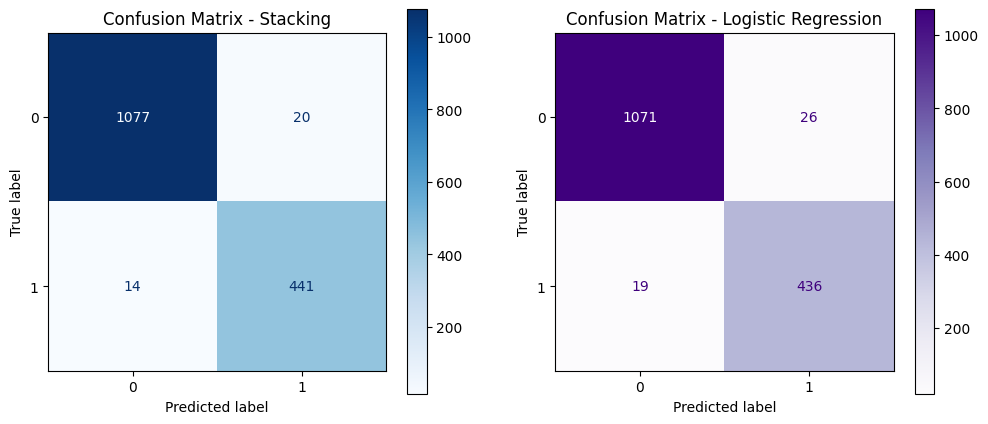

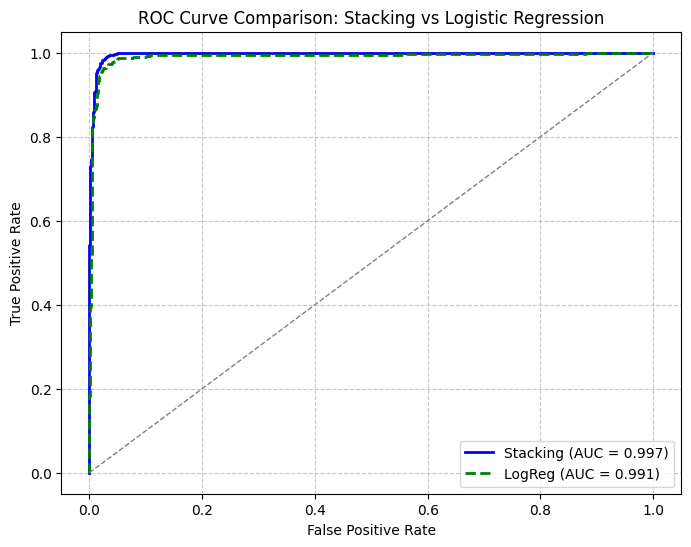

In [63]:
from sklearn.metrics import roc_curve, auc
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

#Predictions
logreg_pred = logreg_model.predict(X_test)
logreg_proba = logreg_model.predict_proba(X_test)[:, 1]

#Eval metrics
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, logreg_pred))
print("ROC-AUC:", roc_auc_score(y_test, logreg_proba))
print("Classification Report:\n", classification_report(y_test, logreg_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, logreg_pred))

#Store results
logreg_results = {
    "Accuracy": accuracy_score(y_test, logreg_pred),
    "ROC_AUC": roc_auc_score(y_test, logreg_proba),
    "Classification_Report": classification_report(y_test, logreg_pred, output_dict=True),
    "Confusion_Matrix": confusion_matrix(y_test, logreg_pred)
}

#Compare with stacking
print("Comparison")
print("Stacking Accuracy:", stacking_results["Test_Accuracy"])
print("LogReg Accuracy  :", logreg_results["Accuracy"])
print("Stacking ROC-AUC :", stacking_results["Test_ROC_AUC"])
print("LogReg ROC-AUC   :", logreg_results["ROC_AUC"])

#Plot confusion matrices for Stacking and Random Forest side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#Stacking Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test, cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Stacking")
#Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    logreg_model, X_test, y_test, cmap="Purples", ax=axes[1])
axes[1].set_title("Confusion Matrix - Logistic Regression")

#ROC Curve - Stacking vs LogReg
fpr_stack, tpr_stack, _ = roc_curve(y_test, test_proba)
roc_auc_stack = auc(fpr_stack, tpr_stack)

fpr_log, tpr_log, _ = roc_curve(y_test, logreg_proba)
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize=(8, 6))
plt.plot(fpr_stack, tpr_stack, color="blue", lw=2,
         label=f"Stacking (AUC = {roc_auc_stack:.3f})")
plt.plot(fpr_log, tpr_log, color="green", lw=2, linestyle="--",
         label=f"LogReg (AUC = {roc_auc_log:.3f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")

plt.title("ROC Curve Comparison: Stacking vs Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

#### Analysis

*As seen in the results, stacking models altogether resulted to a significantly better performance compared to when the models are by themselves. However, stacking took so much time to finish, although that may be due to hardware constraints. Interestingly, that is the case except for RandomForest, where using RandomForest alone yielded a higher accuracy while taking less time to be executed. Overall, the only knock against stacking is that it uses so much computing power and spends so much time just for marginal improvements in the results.*

*I think the benefits of stacking can be further demonstrated for individual models that do poorly on their own, since the main purpose of stacking these models altogether is to get the advantages of each model involved and "patch up" the disadvantages in doing so.*

*Another thing to consider is the combination of the models being stacked. As seen below, a different combination of stacking using the same models yielded different results. In this case, it performed worse, but is still marginally better than the individual models themselves.*

#### Extra: Use a different combination of Stacking

*This one uses SVC and Logistic Regression, then Random Forest as final estimator instead.*

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params for Meta-Learner (RF): {'final_estimator__max_depth': 5, 'final_estimator__max_features': 'sqrt', 'final_estimator__min_samples_leaf': 1, 'final_estimator__min_samples_split': 2, 'final_estimator__n_estimators': 600}
Best ROC-AUC Score (CV): 0.9857713569006364
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1097
           1       0.94      0.95      0.95       455

    accuracy                           0.97      1552
   macro avg       0.96      0.96      0.96      1552
weighted avg       0.97      0.97      0.97      1552

Confusion Matrix:
 [[1071   26]
 [  23  432]]
Stacking Test Accuracy: 0.9684278350515464
Stacking Test ROC-AUC: 0.9914031274104201


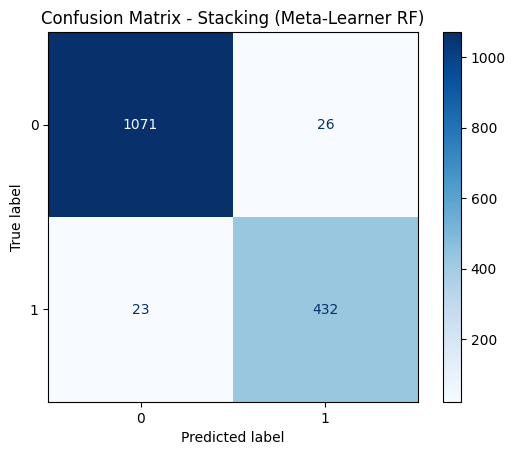

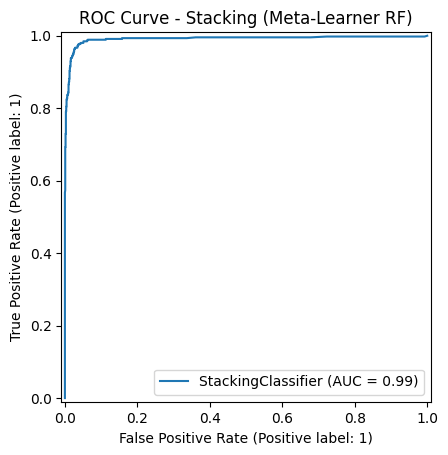

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Base learners
estimators = [
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42)),
    ('svc', SVC(probability=True, kernel="linear", random_state=42))
]

# Stacking model
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5,
    n_jobs=2
)

# Parameter grid for RandomForest meta-learner
param_dist = {
    "final_estimator__n_estimators": [100, 600],
    "final_estimator__max_depth": [5, 10, 20],
    "final_estimator__min_samples_split": [2],
    "final_estimator__min_samples_leaf": [1],
    "final_estimator__max_features": ["sqrt"]
}

#GridSearch
grid_search = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_dist,
    cv=5,
    scoring="roc_auc",
    n_jobs=2,
    verbose=10
)

grid_search.fit(X_train, y_train)

#Best model
best_model_2 = grid_search.best_estimator_
test_pred_2 = best_model_2.predict(X_test)
test_proba_2 = best_model_2.predict_proba(X_test)[:, 1]

#Eval metrics
print("Best Params for Meta-Learner (RF):", grid_search.best_params_)
print("Best ROC-AUC Score (CV):", grid_search.best_score_)
print("Classification Report:\n", classification_report(y_test, test_pred_2))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred_2))
print("Stacking Test Accuracy:", accuracy_score(y_test, test_pred_2))
print("Stacking Test ROC-AUC:", roc_auc_score(y_test, test_proba_2))

#Store results
stacking_results_2 = {
    "Best_Params": grid_search.best_params_,
    "CV_ROC_AUC": grid_search.best_score_,
    "Test_Accuracy": accuracy_score(y_test, test_pred_2),
    "Test_ROC_AUC": roc_auc_score(y_test, test_proba_2),
    "Classification_Report": classification_report(y_test, test_pred_2, output_dict=True),
    "Confusion_Matrix": confusion_matrix(y_test, test_pred_2)
}

#Confusion Matrix Plot
ConfusionMatrixDisplay.from_estimator(best_model_2, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Stacking (Meta-Learner RF)")
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(best_model_2, X_test, y_test)
plt.title("ROC Curve - Stacking (Meta-Learner RF)")
plt.show()

5. Evaluate the different ensemble learning methods used in this activity.

*See visualizations and **analysis** blocks*